In [1]:
import torch
from torch.utils.data import DataLoader

import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt
import cmath
from scipy import integrate
import os
import h5py


# From this project modules:
from IF.src.LSTM_mudule import LSTM
from IF.src.DataProcessing import Propagator_Dataset

# Enable interactive plot
%matplotlib notebook
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

## Plot Input & Output of data generated

In [2]:
# To load the file

directory = './DataLoader/Data/'

h5f = h5py.File(directory+'datadelta.h5', 'r')  # name of file
X_vis = h5f.get('dataset_X')
y_vis = h5f.get('dataset_y')

In [3]:
# General parameters
n_grid = 32  # number of points on the grid
seq_len = 200  # number of steps in trajectories
a = -1.5  # initial point in angstroms
b = 1.5  # final point in angstroms

In [4]:
dat = 3 # Choosing a data

<IPython.core.display.Javascript object>


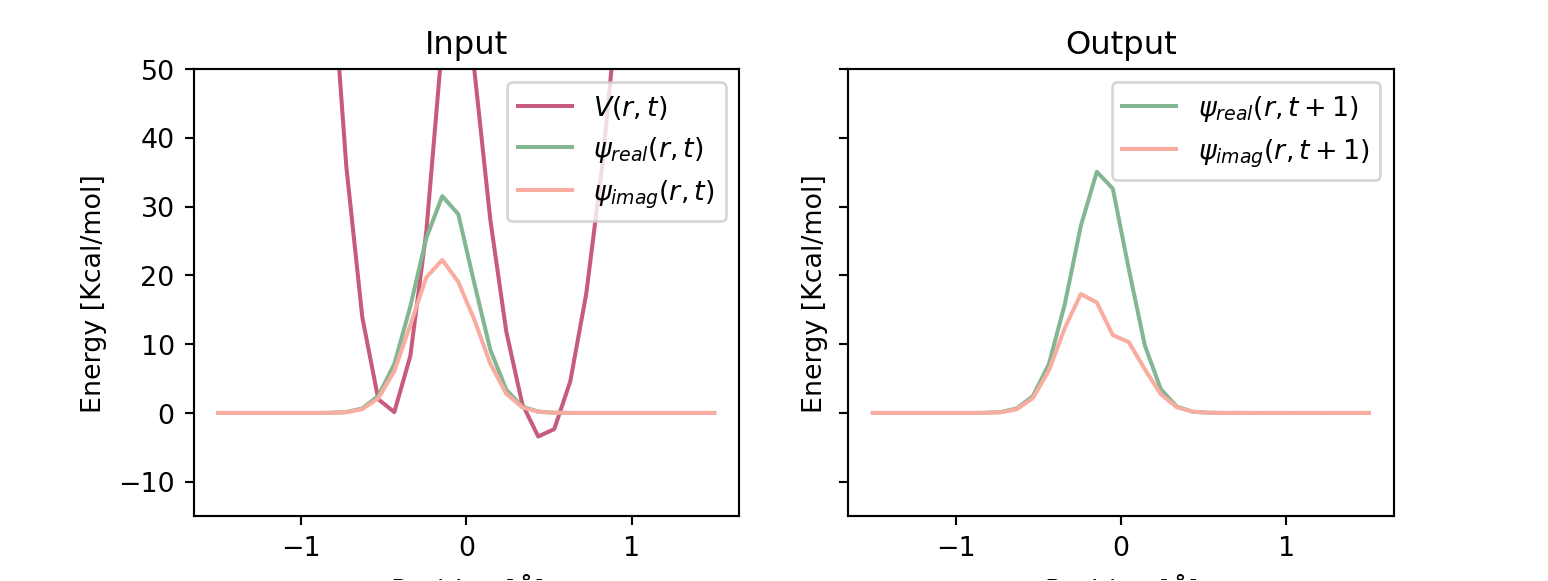

In [5]:
r_n = torch.linspace(a,b,n_grid)
time = int(1)  # Choosing from 0 to seq_len -1

In_real_vis = X_vis[dat,time,0:n_grid]
In_imag_vis = X_vis[dat,time,n_grid:n_grid*2]
In_pote = X_vis[dat,time,n_grid*2:n_grid*3]

Ou_real_vis = y_vis[dat,time,0:n_grid]
Ou_imag_vis = y_vis[dat,time,n_grid:n_grid*2]


fig, axs = plt.subplots(1,2)


# Lenght: au -> Angstroms & au -> kcal/mol
axs[0].plot(r_n, In_pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0].plot(r_n, In_real_vis*30, label="$\psi_{real}(r, t)$", color = color[0])  # Escaled
axs[0].plot(r_n, In_imag_vis*30, label="$\psi_{imag}(r, t)$", color=color[1])  # Escaled
axs[0].set_title("Input")

axs[1].plot(r_n, (In_real_vis + Ou_real_vis)*30, label="$\psi_{real}(r, t+1)$", color = color[0])  # Escaled
axs[1].plot(r_n, (In_imag_vis +Ou_imag_vis)*30, label="$\psi_{imag}(r, t+1)$", color = color[1])  # Escaled
axs[1].set_title("Output")


for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-15, 50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')

plt.gcf().set_size_inches(8, 3)
ax.legend()
plt.show()

## Checking normalization of wave packet at random time t

### [a.u.]

In [ ]:
r_n = np.linspace(a,b,n_grid)*(1/0.5291775)  # angstroms to au
time = int(60)

X_r = X_vis[dat,time,0:n_grid]
X_i = X_vis[dat,time,n_grid:2*n_grid]
X_de = np.vectorize(complex)(X_r,X_i)
X_dens = ((np.abs(X_de))**2)


fig, ax = plt.subplots()
ax.plot(r_n, X_dens)
ax.set(xlabel='Position $[a.u.]$', ylabel='$|\psi(r,t)|^2$   $[1/a.u.]$')
plt.show()

In [ ]:
integrate.simpson(X_dens,r_n)

### [$Å$]

In [ ]:
r_n = np.linspace(a,b,n_grid)
time = int(60)

X_r = X_vis[dat,time,0:n_grid]*np.sqrt(1/0.5291775)
X_i = X_vis[dat,time,n_grid:2*n_grid]*np.sqrt(1/0.5291775)
X_de = np.vectorize(complex)(X_r,X_i)
X_dens = ((np.abs(X_de))**2)# or *(1/0.5291775)


fig, ax = plt.subplots()
ax.plot(r_n, X_dens)
ax.set(xlabel='Position [$\AA$]', ylabel='$|\psi(r,t)|^2$   $[1/\AA]$')
plt.show()

In [ ]:
integrate.simpson(X_dens,r_n)

## Plot comparison LSTM predictions vs DVR

In [6]:
test_path_dat = './DataLoader/Data/datadelta.h5'

In [7]:
dataset = Propagator_Dataset(path=test_path_dat, data='dataset_X', targets='dataset_y')

In [8]:
batch_size = 10

In [9]:
test_loader = DataLoader(dataset, batch_size=batch_size)

In [10]:
for X, y in test_loader:
    print("Test data:")
    print(f"Shape of X in test loader: {X.shape}")
    print(f"Shape of y in test loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Test data:
Shape of X in test loader: torch.Size([10, 200, 96])
Shape of y in test loader: torch.Size([10, 200, 64])
Batch size: 10


In [11]:
# Calling the trained model
device = 'cpu'
model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth',map_location=torch.device('cpu'))

# if cuda is available uncomment:
#model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth')

In [42]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Input = X
    
    Output = y

    with torch.inference_mode():
        Prediction = model(X.float())
    break

In [13]:
print(Input.shape)
print(Prediction.shape)
print(Output.shape)

torch.Size([10, 200, 96])
torch.Size([10, 200, 64])
torch.Size([10, 200, 64])


## Real and Complex parts of wavefunction comparison

In [53]:
def wavefunction(part, time, source):
    
    if source == 'input':
        if part == 'real':
            in_real_t = Input[dat,time,0:n_grid].detach().numpy()
            return in_real_t
        
        if part == 'complex':
            in_imag_t = Input[dat,time,n_grid:n_grid*2].detach().numpy()
            return in_imag_t
        
        
    if source == 'output':
        if part == 'real':
            ou_real_t = Output[dat,time,0:n_grid].detach().numpy()
            return ou_real_t
        
        if part == 'complex':
            ou_imag_t = Output[dat,time,n_grid:n_grid*2].detach().numpy()
            return ou_imag_t
        
    if source == 'prediction':
        if part == 'real':
            pred_real_t = Prediction[dat,time,0:n_grid].detach().numpy()
            return pred_real_t
        
        if part == 'complex':
            pred_imag_t = Prediction[dat,time,n_grid:n_grid*2].detach().numpy()
            return pred_imag_t

In [54]:
def potential(time):
    pot = Input[dat,time,n_grid*2:n_grid*3].detach().numpy()
    return pot

<IPython.core.display.Javascript object>


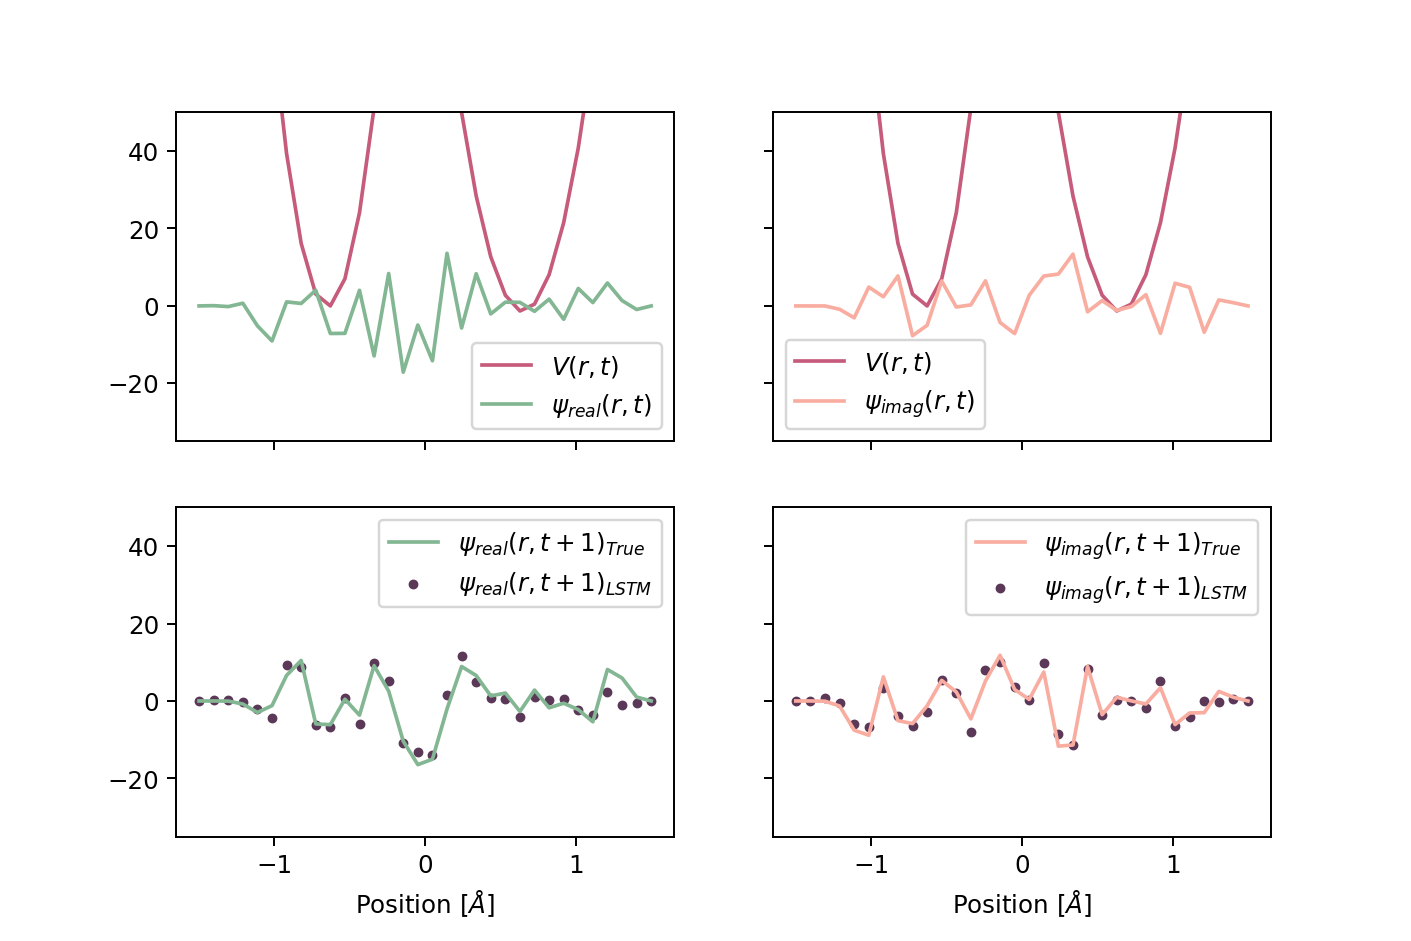

In [55]:
fig, axs = plt.subplots(2,2)
time = int(30)
r_n = np.linspace(a,b,n_grid)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, potential(time)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, wavefunction('real', time, 'input')*20, label="$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, potential(time)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, wavefunction('complex', time, 'input')*20, label="$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, (wavefunction('real', time, 'output')+wavefunction('real', time, 'input'))*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, (wavefunction('real', time, 'prediction')+wavefunction('real', time, 'input'))*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, (wavefunction('complex', time, 'output')+wavefunction('complex', time, 'input'))*20, label="$\psi_{imag}(r, t+1)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, (wavefunction('complex', time, 'prediction')+wavefunction('complex', time, 'input'))*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]')
    ax.label_outer()
    pass
 
plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()

## Density comparison

In [59]:
def density(time, source):
    
    if time == 0:
        dens = (np.abs(np.vectorize(complex)(wavefunction('real',time,'input'),wavefunction('complex', time, 'input'))))**2
        return dens
    
    if source == 'output':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t
    
    if source == 'prediction':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t

<IPython.core.display.Javascript object>


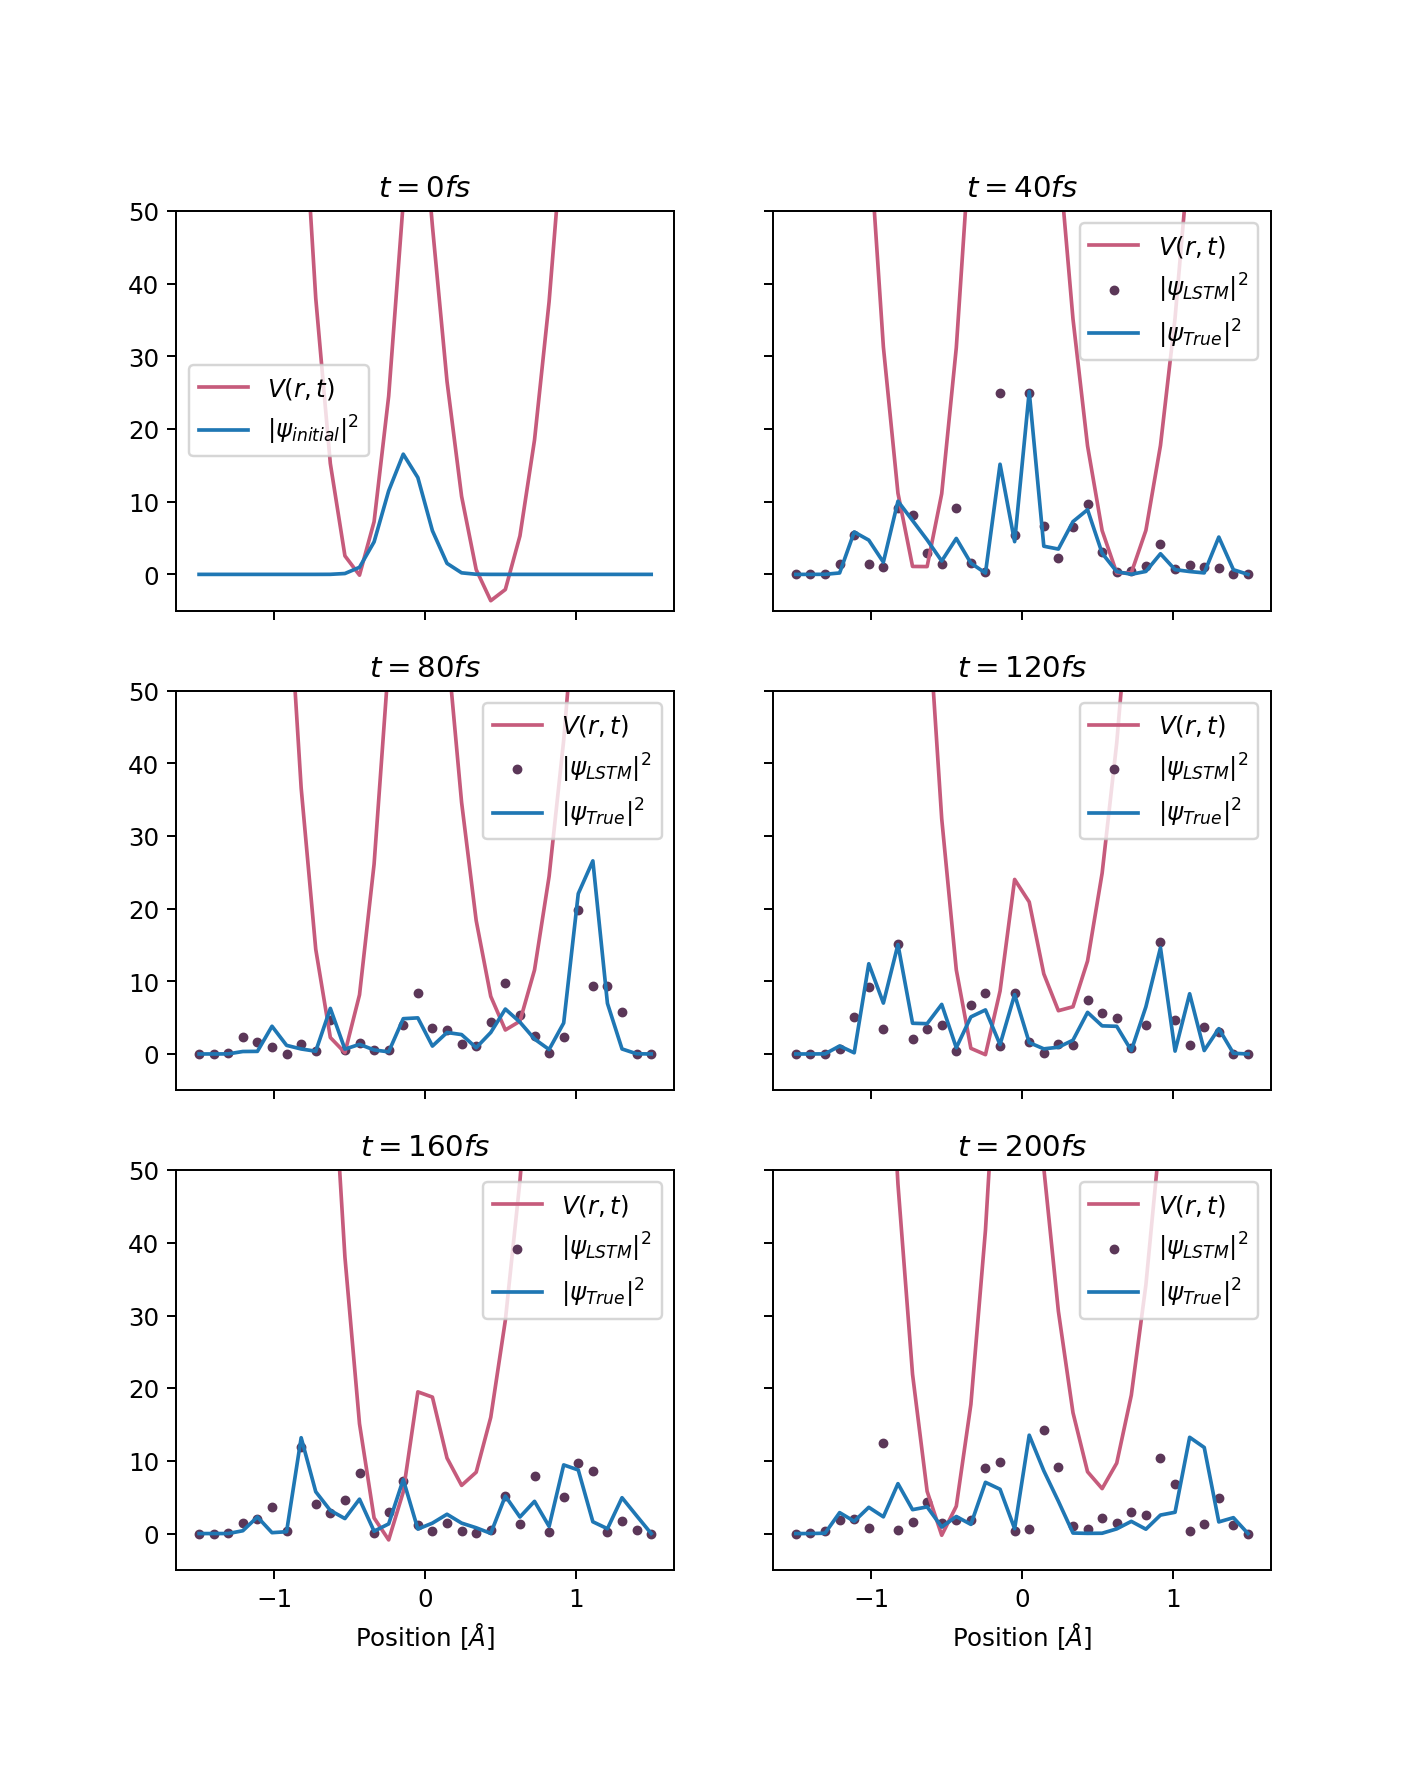

In [60]:
fig, ax = plt.subplots(3,2)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol

# t = 0
ax[0,0].plot(r_n, potential(0)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,0].plot(r_n, density(0, 'output')*10, label="$|\psi_{initial}|^{2}$")
ax[0,0].set_title("$t=0 fs$")

# t = 40
ax[0,1].plot(r_n, potential(40)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,1].scatter(r_n, density(40, 'prediction')*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[0,1].plot(r_n, density(40, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[0,1].set_title("$t=40 fs$")

# t = 80
ax[1,0].plot(r_n, potential(80)*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,0].scatter(r_n, density(80, 'prediction')*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,0].plot(r_n, density(80, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[1,0].set_title("$t=80 fs$")

# t = 120
ax[1,1].plot(r_n, potential(120)*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,1].scatter(r_n, density(120,'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,1].plot(r_n, density(120,'output')*10, label="$|\psi_{True}|^{2}$")
ax[1,1].set_title("$t=120 fs$")

# t = 160
ax[2,0].plot(r_n, potential(160)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,0].scatter(r_n, density(160,'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,0].plot(r_n, density(160, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[2,0].set_title("$t=160 fs$")

# t = 200
ax[2,1].plot(r_n, potential(199)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,1].scatter(r_n, density(199, 'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,1].plot(r_n, density(199, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[2,1].set_title("$t=200 fs$")







for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-5, 50])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(8, 10)
#plt.legend()    
plt.show()